# Import package

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
sns.set(style = 'whitegrid',context = 'notebook')

# generate classification report using predictions for categorical model
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn import (metrics,  linear_model, preprocessing)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 175)

# Import data

In [3]:
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [4]:
original_df = df.copy()

In [5]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [6]:
df.shape

(768, 9)

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


# Preprocessing Data

In [8]:
df = df.fillna(df.mean())
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
num_vars = [var for var in df.columns if df[var].dtypes != 'O']
numdf = df[num_vars].drop(['Outcome'],axis=1)

from sklearn.preprocessing import MinMaxScaler
numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns

In [10]:
X = numdf_norm
print (X.shape)
y = df['Outcome']
print (y.shape)

(768, 8)
(768,)


## Spliting data into training and test set

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
X_train.shape, X_test.shape

((614, 8), (154, 8))

# Train and perform cross validation

In [12]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

kfold = KFold(n_splits = 10, random_state = 10)
scores = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
scores

array([0.74193548, 0.62903226, 0.74193548, 0.74193548, 0.7704918 ,
       0.80327869, 0.85245902, 0.7704918 , 0.73770492, 0.70491803])

In [13]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 74.94% (+/- 11.17%)


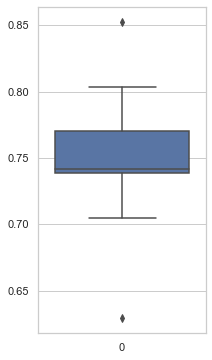

In [14]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

# Prediction

In [15]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
prob_test_pred = model.predict_proba(X_test)

# Model Evaluation

### Accuracy

In [16]:
accuracy_score(y_train, y_train_pred)

0.8192182410423453

In [17]:
accuracy_score(y_test, y_test_pred)

0.7597402597402597

### Confusion matrix

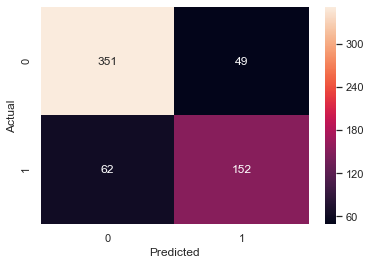

In [20]:
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

In [21]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       400
           1       0.76      0.71      0.73       214

    accuracy                           0.82       614
   macro avg       0.80      0.79      0.80       614
weighted avg       0.82      0.82      0.82       614



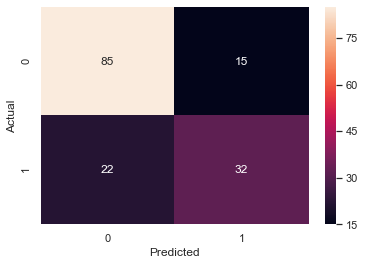

In [22]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

### Classification Report

In [23]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154



### ROC AUC Score

In [24]:
roc_auc_score(y_train, prob_train_pred[:,1])

0.916746495327103

In [25]:
roc_auc_score(y_test, prob_test_pred[:,1])

0.8387037037037037

### ROC Curve

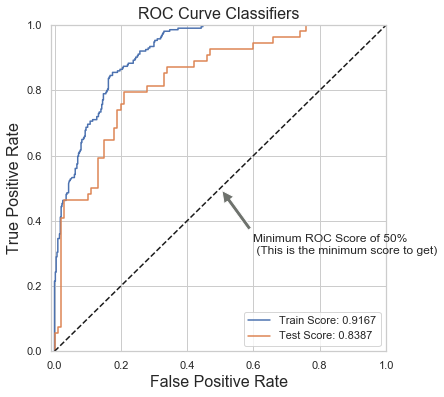

In [26]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


### Precision-Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.74')

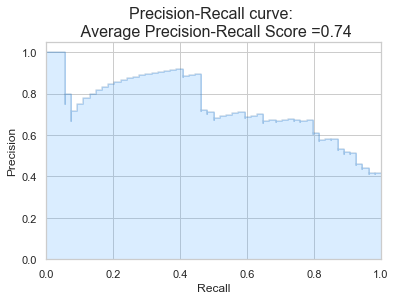

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

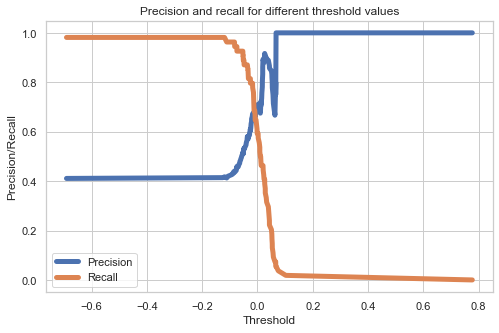

In [28]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.85')

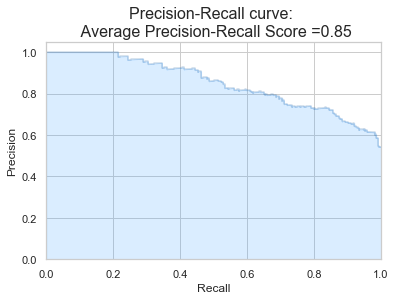

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_train)
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

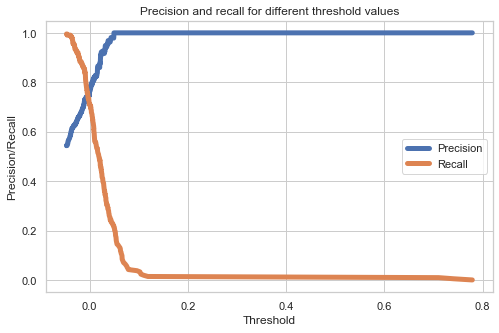

In [30]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [31]:
threshold

array([-4.69156357e-02, -4.67922591e-02, -4.57857459e-02, -4.55154601e-02,
       -4.54779976e-02, -4.49456796e-02, -4.48919547e-02, -4.44169862e-02,
       -4.43853686e-02, -4.43653456e-02, -4.41912434e-02, -4.41486072e-02,
       -4.41405500e-02, -4.36418075e-02, -4.36155923e-02, -4.35019843e-02,
       -4.30891336e-02, -4.29721282e-02, -4.28784664e-02, -4.21536023e-02,
       -4.14139103e-02, -4.12162465e-02, -4.07038663e-02, -4.05497109e-02,
       -4.04483230e-02, -4.02956943e-02, -4.00233566e-02, -3.99025418e-02,
       -3.92546486e-02, -3.91372145e-02, -3.91148682e-02, -3.89476507e-02,
       -3.87379203e-02, -3.86487462e-02, -3.85667583e-02, -3.82284081e-02,
       -3.81854442e-02, -3.81723639e-02, -3.80891593e-02, -3.78612466e-02,
       -3.78561445e-02, -3.74649298e-02, -3.70942428e-02, -3.66799106e-02,
       -3.66074180e-02, -3.65849334e-02, -3.65138525e-02, -3.63892082e-02,
       -3.62870538e-02, -3.61733799e-02, -3.57517835e-02, -3.54424750e-02,
       -3.50051142e-02, -

### Summary

In [32]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))
    

In [33]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'DT')

Model Evaluation of DT
-----------------------------------------------------------
Train set
Accuracy:  0.8192182410423453
ROC AUC Score:  0.916746495327103
Confusion matrix
True         0    1
Predicted          
0          351   49
1           62  152
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       400
           1       0.76      0.71      0.73       214

    accuracy                           0.82       614
   macro avg       0.80      0.79      0.80       614
weighted avg       0.82      0.82      0.82       614

-----------------------------------------------------------
Test set
Accuracy:  0.7597402597402597
ROC AUC Score:  0.8387037037037037
Confusion matrix
True        0   1
Predicted        
0          85  15
1          22  32
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                    

# Tuning hyper-parameters

In [34]:
params = 
grid_search = GridSearchCV(DecisionTreeClassifier(), params)
grid_search.fit(X_train, y_train)

# tree best estimator
best_model = grid_search.best_estimator_
best_model

SyntaxError: invalid syntax (<ipython-input-34-c6d721b9297d>, line 1)

In [35]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

NameError: name 'best_model' is not defined

In [44]:
scores

array([0.90322581, 0.82258065, 0.90322581, 0.83870968, 0.91803279,
       0.75409836, 0.83606557, 0.83606557, 0.95081967, 0.83606557])

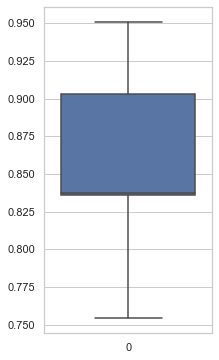

In [45]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

In [46]:
from sklearn.tree import DecisionTreeClassifier
model = best_model

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
prob_test_pred = model.predict_proba(X_test)

NameError: name 'best_model' is not defined

In [47]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'DT')

Model Evaluation of DT
-----------------------------------------------------------
Train set
Accuracy:  0.9218241042345277
ROC AUC Score:  0.9811923595039894
Confusion matrix
True         0    1
Predicted          
0          370   23
1           25  196
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       393
           1       0.89      0.89      0.89       221

    accuracy                           0.92       614
   macro avg       0.92      0.91      0.91       614
weighted avg       0.92      0.92      0.92       614

-----------------------------------------------------------
Test set
Accuracy:  0.8766233766233766
ROC AUC Score:  0.933187512427918
Confusion matrix
True        0   1
Predicted        
0          94  13
1           6  41
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       107
           1       0.76      0.87      0.81        47

    accuracy                    

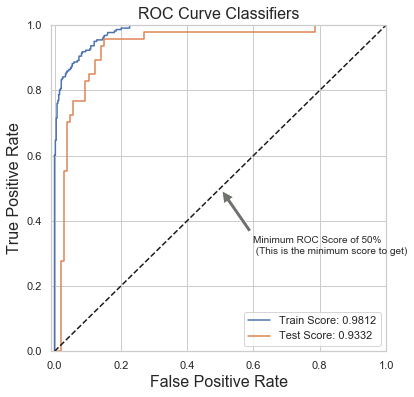

In [48]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()
